# テキストデータの分類

ニュースフィードのカテゴリを教師データとし、カテゴリを予測

1. ニュースフィードから教師データを作成
2. 英語テキストの前処理、ベクトル化
3. 分類モデルの作成（学習）
4. 精度の検証

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer

# matplotlib: 日本語フォントの設定
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 
                               'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']

# フィードデータの読み込み
feeds = pd.read_csv('data/output_en.csv')
# 文字列を結合
feeds['text'] = feeds['title'].str.cat(feeds['summary'], sep='. ', na_rep='')
# 不要になった列の削除
df = feeds.drop(['title', 'summary'], axis=1)
# URLの確認
#print(df.url.unique())
# 確認
df.head(1)

,url,text
0,http://feeds.bbci.co.uk/news/rss.xml,Conservative peer Michelle Mone to take leave ...


### 教師データの作成

URLに基づいた教師ラベルの設定：

label 0
- business
- economy
- politics

label 1
- education
- entertainment
- health
- lifestyle
- science
- sport

label 2
- 上記以外

In [2]:
label_0 = ['business', 'economy', 'politics']
label_1 = ['education', 'entertainment', 'health', 'lifestyle', 'science', 'sport']

# label_0 の単語が url の中に含まれている：0
# label_1 の単語が url の中に含まれている：1
# それ以外：2
def get_label(url):
    url = url.lower()
    # map: label_0 の単語それぞれについて、url の中に含まれているか真偽を返す
    # any: mapの結果について論理和をとる
    if any(map(lambda x: x in url, label_0)):
        return 0
    if any(map(lambda x: x in url, label_1)):
        return 1
    else:
        return 2

# df['url'] について get_label を適用した結果を df['label'] として追加
df['label'] = df['url'].map(lambda x: get_label(x))
# 各ラベルの数を確認
df['label'].value_counts()

2    1276
0     495
1      58
Name: label, dtype: int64

In [3]:
# label 0, 1 を取り出す
df = df.query('label != 2')
# 数を確認
df['label'].value_counts()

0    495
1     58
Name: label, dtype: int64

### 英語テキストに対する前処理

トークン化（単語に分割）、小文字化、ストップワードの除去、ステミング、見出し語化

In [4]:
symbols_to_remove = r'["`,.' + r"'" + r']'
stop_words = nltk.corpus.stopwords.words('english')
stop_words += ["'", '"', ':', ';', '.', ',', '-', '!', '?', "'s", '`', '•', '%']
stop_words += ['–', '—', '‘', '’', '“', '”', '…', '|', '#', '$', '&', "''", '(', ')']
stemmer = nltk.stem.porter.PorterStemmer()
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

# 品詞の名称を変換
def wordnet_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    return None

def preprocess(text):
    tokens = []
    # 品詞のタグ付けをした各トークンについて
    for t in nltk.pos_tag(nltk.tokenize.word_tokenize(text.replace('-', ' '))):
        # 小文字化
        t0 = t[0].lower()
        # 不要な文字の削除
        t0 = re.sub(symbols_to_remove, '', t0)
        # 空文字列になったら次へ
        if t0 == '':
            continue
        # stop_words に含まれていないトークンのみを残す
        if t0 in stop_words:
            continue
        # カンマ区切りが入った数値からカンマを削除
        if t[1] == 'CD':
            t0 = t0.replace(',', '')
        # 見出し語化
        tag = wordnet_tag(t[1])
        if tag is None:
            t0 = lemmatizer.lemmatize(t0)
        else:
            t0 = lemmatizer.lemmatize(t0, tag)
        # ステミング
        t0 = stemmer.stem(t0)
        # リストに追加
        tokens.append(t0)
    # トークンのリストを返す
    return tokens

### テキストのベクトル化

In [5]:
# BoW 初期化
vectorizer = CountVectorizer(tokenizer=preprocess)
# ベクトル化
vector = vectorizer.fit_transform(df.text)

### 分類モデルの作成（学習）

- ナイーブベイズ分類器

正確度: 0.993, 適合度: 0.950, 再現率: 0.983, 特異度: 0.994


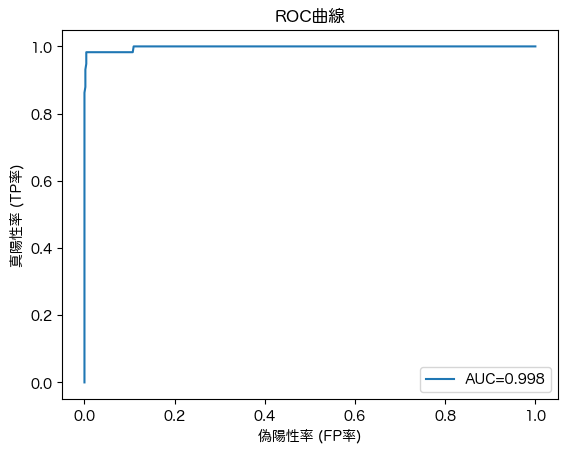

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB

# 説明変数、目的変数
# - vector が sparse のため toarray() により dense に変換
X = vector.toarray()
Y = df.label

# ナイーブベイズ分類器
# - 特徴量（説明変数）は整数のカウントデータ（単語の出現頻度など）
model = MultinomialNB()

# 学習
model.fit(X, Y)
# 教師データについてモデルからの予測値を計算
Y_predict = model.predict(X)

# 特異度の計算
matrix = confusion_matrix(Y, Y_predict)
specificity = matrix[0, 0] / (matrix[0, 1] + matrix[0, 0])
# 精度
print('正確度: {:.3f}, 適合度: {:.3f}, 再現率: {:.3f}, 特異度: {:.3f}'.format(
    accuracy_score(Y, Y_predict), precision_score(Y, Y_predict),
    recall_score(Y, Y_predict), specificity))
# ROC, AUC
Y_proba = model.predict_proba(X)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
plt.plot(fpr, tpr, label='AUC={:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('偽陽性率 (FP率)')
plt.ylabel('真陽性率 (TP率)')
plt.title('ROC曲線')
plt.legend()
plt.show()

### 交差検証法により予測精度を検証

- ナイーブベイズ分類器

In [8]:
from sklearn.model_selection import cross_val_score

# 交差検証の実行
score = cross_val_score(model, X, Y, cv=10, scoring='roc_auc')
print('AUC={:.3f} (+/- {:.3f})'.format(score.mean(), score.std()))

AUC=0.952 (+/- 0.059)


### その他の分類器

- ロジスティック回帰
- 決定木
- ランダムフォレスト
- SVM

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = [
    MultinomialNB(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC()
]

for model in models:
    # 交差検証の実行
    # - %time: 行の実行時間の計測
    %time score = cross_val_score(model, X, Y, cv=5, scoring='roc_auc')
    print('{}: AUC={:.3f} (+/- {:.3f})'.format(model, score.mean(), score.std()))

CPU times: user 210 ms, sys: 5.1 ms, total: 215 ms
Wall time: 38.4 ms
MultinomialNB(): AUC=0.953 (+/- 0.028)
CPU times: user 2.33 s, sys: 74.3 ms, total: 2.4 s
Wall time: 369 ms
LogisticRegression(): AUC=0.965 (+/- 0.029)
CPU times: user 1.71 s, sys: 53.3 ms, total: 1.76 s
Wall time: 338 ms
DecisionTreeClassifier(): AUC=0.758 (+/- 0.062)
CPU times: user 637 ms, sys: 11.1 ms, total: 649 ms
Wall time: 650 ms
RandomForestClassifier(): AUC=0.898 (+/- 0.032)
CPU times: user 1.44 s, sys: 13.8 ms, total: 1.45 s
Wall time: 1.46 s
SVC(): AUC=0.968 (+/- 0.035)
